In [2]:
"""
Script de preprocesamiento para el proyecto de pronóstico de cancelación de clientes de Interconnect

Objetivos:
1. Cargar y explorar los datos de diferentes fuentes
2. Realizar limpieza y transformación de datos
3. Enriquecer los datos con nuevas características
4. Preparar los datos para el modelado predictivo

Archivos de entrada:
- contract.csv: Información de contratos
- personal.csv: Datos personales de clientes
- internet.csv: Servicios de internet
- phone.csv: Servicios telefónicos

Archivo de salida:
- dataframe.feather: Dataset preprocesado listo para modelado
"""

'\nScript de preprocesamiento para el proyecto de pronóstico de cancelación de clientes de Interconnect\n\nObjetivos:\n1. Cargar y explorar los datos de diferentes fuentes\n2. Realizar limpieza y transformación de datos\n3. Enriquecer los datos con nuevas características\n4. Preparar los datos para el modelado predictivo\n\nArchivos de entrada:\n- contract.csv: Información de contratos\n- personal.csv: Datos personales de clientes\n- internet.csv: Servicios de internet\n- phone.csv: Servicios telefónicos\n\nArchivo de salida:\n- dataframe.feather: Dataset preprocesado listo para modelado\n'

In [3]:
# ====================
# IMPORTACIÓN DE LIBRERÍAS
# ====================
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys, os
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [4]:
# Configuración de rutas del proyecto
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

In [5]:
# Importación de funciones personalizadas
from functions.f01_preprocesing_functions import df_explore, df_ValuesCheck

In [6]:
# ====================
# CARGA DE DATOS
# ====================
print("Cargando datasets...")
contract = pd.read_csv(project_root/'datasets/contract.csv')
personal = pd.read_csv(project_root/'datasets/personal.csv')
internet = pd.read_csv(project_root/'datasets/internet.csv')
phone = pd.read_csv(project_root/'datasets/phone.csv')

Cargando datasets...


In [7]:
# Exploración inicial de los datos
print("\nExploración inicial de los datasets:")
print("1. Dataset de contratos:")
df_explore(contract)
print("\n2. Dataset de datos personales:")
df_explore(personal)
print("\n3. Dataset de servicios de internet:")
df_explore(internet)
print("\n4. Dataset de servicios telefónicos:")
df_explore(phone)


Exploración inicial de los datasets:
1. Dataset de contratos:
Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

Primeras filas del DataFrame:
   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Mon

In [8]:
# ====================
# PREPROCESAMIENTO DEL DATASET DE CONTRATOS
# ====================
print("\nPreprocesando dataset de contratos...")


Preprocesando dataset de contratos...


In [9]:
# 1. Creación de variable target (Churn)
contract['Churn'] = np.where(contract['EndDate'] == 'No', 0, 1)

In [10]:
# 2. Conversión de tipos de datos
contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], errors='coerce')
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

/var/folders/p5/ktpmth0j3514y8d1c9x8sd_00000gn/T/ipykernel_87287/3717321001.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')


In [11]:
# 3. Cálculo de duración del plan en meses
LastDate = pd.to_datetime('2020-02-01')  # Fecha de referencia
contract['PlanDurationMonths'] = ((contract['EndDate']-contract['BeginDate']).dt.days)/30
contract.loc[contract['EndDate'].isna(), 'PlanDurationMonths'] = ((LastDate - contract['BeginDate']).dt.days)/30
contract['PlanDurationMonths'] = np.round(contract['PlanDurationMonths']).astype('Int64')

In [12]:
# 4. Imputación de valores faltantes en TotalCharges
mask = contract['TotalCharges'].isna()
contract.loc[mask, 'TotalCharges'] = contract.loc[mask, 'MonthlyCharges'] * contract.loc[mask, 'PlanDurationMonths']

In [13]:
# 5. Eliminación de columnas no relevantes
contract = contract.drop(['PaperlessBilling', 'PaymentMethod'], axis=1)


Visualizando relaciones clave...


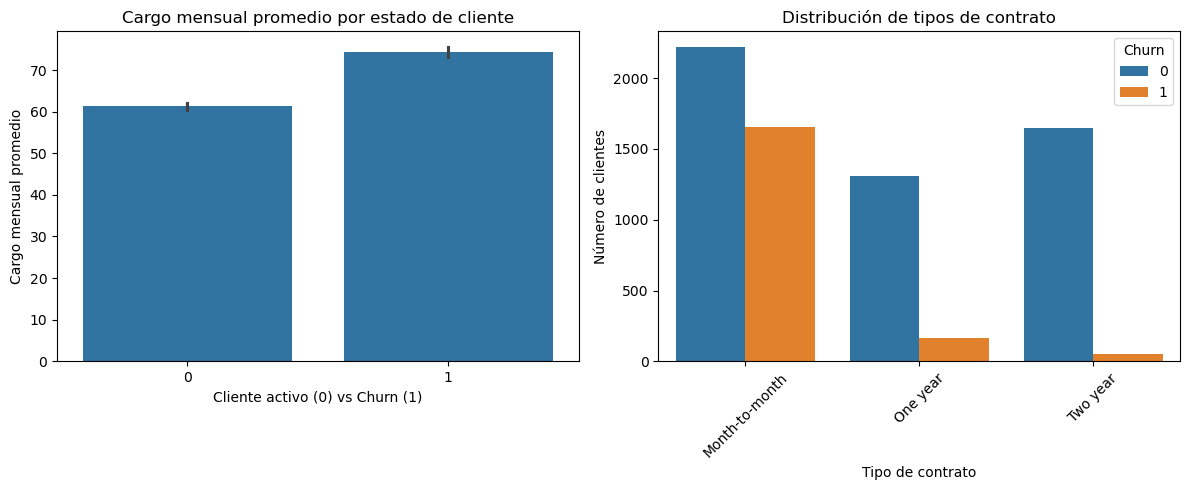

In [14]:
# Visualizaciones para entender los datos
print("\nVisualizando relaciones clave...")
plt.figure(figsize=(12, 5))
# Relación entre Churn y MonthlyCharges
plt.subplot(1, 2, 1)
sns.barplot(x='Churn', y='MonthlyCharges', data=contract)
plt.title('Cargo mensual promedio por estado de cliente')
plt.xlabel('Cliente activo (0) vs Churn (1)')
plt.ylabel('Cargo mensual promedio')

# Distribución de tipos de contrato
plt.subplot(1, 2, 2)
sns.countplot(x='Type', hue='Churn', data=contract)
plt.title('Distribución de tipos de contrato')
plt.xlabel('Tipo de contrato')
plt.ylabel('Número de clientes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
# ====================
# PREPROCESAMIENTO DE LOS DEMÁS DATASETS
# ====================
print("\nRevisando valores ausentes y duplicados")
df_ValuesCheck(personal)
df_ValuesCheck(internet)
df_ValuesCheck(phone)


Revisando valores ausentes y duplicados
Columnas con valores ausentes: customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Filas totalmente duplicadas: 0

Duplicados en columna customerID: 0
Columnas con valores ausentes: customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Filas totalmente duplicadas: 0

Duplicados en columna customerID: 0
Columnas con valores ausentes: customerID       0
MultipleLines    0
dtype: int64

Filas totalmente duplicadas: 0

Duplicados en columna customerID: 0


In [16]:
# ====================
# INTEGRACIÓN DE DATASETS
# ====================
print("\nIntegrando todos los datasets...")
df = contract.merge(personal, on='customerID', how='left')
df = df.merge(internet, on='customerID', how='left')
df = df.merge(phone, on='customerID', how='left')


Integrando todos los datasets...


In [17]:
# ====================
# LIMPIEZA FINAL
# ====================
# 1. Imputación de valores faltantes en servicios
columns_to_fill = [
    'MultipleLines', 'OnlineSecurity', 'DeviceProtection', 
    'OnlineBackup', 'TechSupport', 'StreamingTV', 'StreamingMovies'
]
df[columns_to_fill] = df[columns_to_fill].fillna('No')

In [18]:
# 2. Eliminación de columnas no relevantes
df = df.drop(['customerID', 'BeginDate', 'EndDate', 'gender'], axis=1)

In [19]:
# ====================
# ENCODING DE VARIABLES CATEGÓRICAS
# ====================
print("\nRealizando encoding de variables categóricas...")
df_encoded = df.copy()


Realizando encoding de variables categóricas...


In [20]:
# 1. One-Hot Encoding para variables nominales
nominal_cols = ['Partner', 'Dependents', 'InternetService', 'MultipleLines']
ohe = OneHotEncoder(drop='first', sparse_output=False)
ohe_result = ohe.fit_transform(df_encoded[nominal_cols])

In [21]:
# Nombres para las nuevas columnas
ohe_columns = []
for i, col in enumerate(nominal_cols):
    for cat in ohe.categories_[i][1:]:
        ohe_columns.append(f"{col}_{cat}")

In [22]:
# Creación de DataFrame con las nuevas columnas
ohe_df = pd.DataFrame(ohe_result, columns=ohe_columns, index=df_encoded.index)
df_encoded = pd.concat([df_encoded, ohe_df], axis=1)
df_encoded.drop(nominal_cols, axis=1, inplace=True)

In [23]:
# 2. Ordinal Encoding para variables ordinales
ordinal_cols = {'Type': ['Month-to-month', 'One year', 'Two year']}
ordinal_encoder = OrdinalEncoder(categories=[ordinal_cols['Type']])
df_encoded['Type_encoded'] = ordinal_encoder.fit_transform(df_encoded[['Type']])
df_encoded.drop('Type', axis=1, inplace=True)

In [24]:
# 3. Binary Encoding para servicios con respuestas Yes/No
binary_cols = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]

In [25]:
for col in binary_cols:
    df_encoded[f"{col}_bin"] = df_encoded[col].map({'Yes': 1, 'No': 0})

In [26]:
df_encoded.drop(binary_cols, axis=1, inplace=True)

In [27]:
df_encoded

,MonthlyCharges,TotalCharges,Churn,PlanDurationMonths,SeniorCitizen,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_nan,MultipleLines_Yes,Type_encoded,OnlineSecurity_bin,OnlineBackup_bin,DeviceProtection_bin,TechSupport_bin,StreamingTV_bin,StreamingMovies_bin
0,29.85,29.85,0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
1,56.95,1889.50,0,35,0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,1,0,0,0
2,53.85,108.15,1,2,0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0,0,0
3,42.30,1840.75,0,46,0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,1,1,0,0
4,70.70,151.65,1,2,0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,84.80,1990.50,0,24,0,1.0,1.0,0.0,0.0,1.0,1.0,1,0,1,1,1,1
7039,103.20,7362.90,0,73,0,1.0,1.0,1.0,0.0,1.0,1.0,0,1,1,0,1,1
7040,29.60,346.45,0,11,0,1.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
7041,74.40,306.60,1,4,1,1.0,0.0,1.0,0.0,1.0,0.0,0,0,0,0,0,0


In [28]:
# ====================
# GUARDADO DEL DATASET FINAL
# ====================
print("\nGuardando dataset preprocesado...")
df_encoded.to_feather(f'{project_root}/datasets/a01_ETL.feather')
print("Proceso completado exitosamente!")


Guardando dataset preprocesado...
Proceso completado exitosamente!
